# **Capstone Project - The Battle of Neighborhoods**
---

## Table of contents
* [Introduction](#introduction)
* [Data Sources](#data)
* [Methodology:](#methodology) [Data Collection and](#data_collection) [Data Analysis](#data_analysis)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>
**Background**:

* The café and coffee shop industry is an important industry in terms of employment and contribution to the UK economy, according to "Investigating the Success of Independent Coffee Shops and Cafes in the UK: Findings from a Pilot Study" (by Jacqueline Douglas, Alexander Douglas, Michele Cano, David Moyes). 
* However, sustainability in terms of longevity is an issue. Despite the low barriers to entry into the industry, cafés are a very high risk business and most start-ups fail. According to the *Office for National Statistics*, only 34.6% of accommodation and food services survive longer than five years (*Office for National Statistics, 2016*).
* It's clear that to survive coffee shops owners need to have some feedback from their clients. The feedback should be analyzed (in this research with the help of Machine Learning) and interpreted, as with this information, entrepreneurs can react and change their coffee shops according to their customers opinions and prosper in this business area.

**Business Problem**:

In this research, the Foursquare Rating has been chosen as the measure of the customers' loyalty for the venues, which have placed their menus on the Foursquare Website.
The aim of this research project is to determine if the connection between Foursquare Rating (customers loyalty measure) and availability of the most popular items in a coffee shop menu exists (also the prices for these most popular items are being taken into consideration).



## Data Sources <a name="data"></a>

* Foursquare Rating is based on a number of signals that from social data mines (likes and dislikes, and positive versus negative tips). It's going to be used as the main measure of the project, as the goal is to find the connection between this metric and availability in the published menus the most popular of the coffee shop items.
* Published on the Foursquare, coffee shop Menus with the items and their prices.
* Foursquare Geospatial Data - latitude and longitude of the venues.
* Some additional information: number of the coffee shop photos, number of guest tips, etc.
* Wikipedia page with the list of the districts of London ordered by population density, based on population estimates for 2019.
https://en.wikipedia.org/wiki/List_of_English_districts_by_population_density


## Methodology<a name="methodology"></a>

* Data Collection:

    1. Import of the Python libraries.
    2. Getting the list of the London districts from the Wikipedia.
    3. Foursquare API, getting the venues for the London districts from the previous step.
    4. Foursquare API, getting the data of every venue (venue's rating, URL, number of photos and tips, etc.).
    5. Web crawling, getting the menu (items and prices) for every venue.
    6. Data cleaning.
    7. Identification of the most popular items in the obtained menus.
    8. Representation on the map analyzed coffee shops.  
    

* Data Analysis:

    1. Data preparation.
    2. Linear Regression construction.
    3. Random Forest Regression construction.

## Data Collection <a name="data_collection"></a>
---

1. Import of the necessary for the research Python libraries.

In [1]:
import lxml
import time
import folium
import random
import requests
import warnings
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors

from bs4 import BeautifulSoup
from matplotlib import pyplot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from pandas.io.json import json_normalize
from sklearn.ensemble import RandomForestRegressor

Setting of some visualization parameters.

In [2]:
%matplotlib notebook
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

2. Getting the list of the London districts from the Wikipedia page with density more than 10,000 per km²:
https://en.wikipedia.org/wiki/List_of_English_districts_by_population_density.

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_English_districts_by_population_density'
soup = BeautifulSoup(requests.get(url).text,features = 'lxml')
table = soup.find_all(class_ = 'wikitable')
t = pd.read_html(str(table))[0]
neighborhoods = t.copy()
neighborhoods['neighborhood'] = t['District'] + ', London, Greater London, United Kingdom'
neighborhoods = neighborhoods[['neighborhood']]
neighborhoods

,neighborhood
0,"Islington, London, Greater London, United Kingdom"
1,"Tower Hamlets, London, Greater London, United ..."
2,"Hackney, London, Greater London, United Kingdom"
3,"Kensington and Chelsea, London, Greater London..."
4,"Lambeth, London, Greater London, United Kingdom"
5,"Camden, London, Greater London, United Kingdom"
6,"Westminster, London, Greater London, United Ki..."
7,"Hammersmith and Fulham, London, Greater London..."
8,"Southwark, London, Greater London, United Kingdom"


In [4]:
CLIENT_ID = 'M5QE21FVOFLBC5SHM4GPU2ETFQ4DXIYPWFAFX1S1BJUGH0AP'
CLIENT_SECRET = 'HLPNQSI5ICRNSLXTPZ4PEARAGFCKI1AYNYTP5AFV1WY5S2HH'
VERSION = '20190425'

3. We will get from Foursquare API the list of the venues, located in the obtained from Wikipedia London districts.

For that, we will execute the API-call function, which will retrieve the venues in 900 meters distance from the neighborhood center. 

In [5]:
def getNearbyVenues(neighborhoods,category,radius = 900,limit = 3):
    venues_list = []
    for neighborhood in zip(neighborhoods):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID,CLIENT_SECRET,VERSION,neighborhood,category,radius,limit)
        results = requests.get(url).json()['response']['groups'][0]['items']        
        venues_list.append([(neighborhood[0],
                             v['venue']['id'],
                             v['venue']['name'],
                             v['venue']['location']['lat'],
                             v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name'])
                            for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood',
                             'venue_id',
                             'venue_name',
                             'venue_latitude',
                             'venue_longitude',
                             'venue_category']
    return(nearby_venues)

In [6]:
cat = '4bf58dd8d48988d1e0931735' # the coffee shops category
neighborhood_venue = getNearbyVenues(neighborhoods = neighborhoods['neighborhood'],category = cat,limit = 495)
neighborhood_venue.head()

,neighborhood,venue_id,venue_name,venue_latitude,venue_longitude,venue_category
0,"Islington, London, Greater London, United Kingdom",58a576b8f8572431aec041b8,Kobo Cafe,51.534988,-0.104149,Café
1,"Islington, London, Greater London, United Kingdom",584bfe4544587f042f5ff30c,Katsute 100,51.534286,-0.104540,Tea Room
2,"Islington, London, Greater London, United Kingdom",4fc9ff8ce4b087d229f75ce4,The Coffeeworks Project,51.534254,-0.104684,Coffee Shop
3,"Islington, London, Greater London, United Kingdom",50338ecbe4b0c160f73b46d0,Giddy Up,51.536374,-0.102930,Coffee Shop
4,"Islington, London, Greater London, United Kingdom",5a9ea6c2d03360028695111e,Six Degrees,51.535228,-0.103486,Coffee Shop


So, in the given dataframe we have the neighborhood, venue id, venue name, venue's latitude, longitude, and category.

4. Now, let's get the Foursquare Rating and other valuable information (url, number of tips, photos, etc.) for every venue.

In [8]:
def get_venue_data(venues):
    venues_list = []
    for vn in venues:
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(vn,CLIENT_ID,CLIENT_SECRET,VERSION)
        global results
        try:
            results = requests.get(url).json()['response']['venue']
        except:
            print(vn,'Something went wrong with the Foursquare response')
            pass     
        try:
            venues_list.append([(results['id'],
                                 results['name'],
                                 results['location']['formattedAddress'],
                                 results['canonicalUrl'],
                                 results['categories'][0]['name'],
                                 results['verified'],
                                 results['stats']['tipCount'],
                                 results['price']['tier'],
                                 results['price']['message'],
                                 results['price']['currency'],
                                 results['rating'],
                                 results['photos']['count'],
                                 results['tips']['count']
                                )])
        except:
            print(vn,'Something went wrong, critical data is missing')
            pass
    df_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    df_venues.columns = ['v_id',
                         'name',
                         'formattedAddress',
                         'canonicalUrl',
                         'categories',
                         'verified',
                         'tipCount',
                         'tier',
                         'message',
                         'currency',
                         'rating',
                         'photos',
                         'tips'
                        ]
    return(df_venues)

In [9]:
df = pd.concat([neighborhood_venue,get_venue_data(neighborhood_venue['venue_id'])],axis = 1,join = 'inner')
df = df[['neighborhood','venue_id','venue_name','venue_latitude','venue_longitude','venue_category','canonicalUrl'
         ,'categories','tier','message','rating','photos','tips']]
#df.head()

5cb32d7bad910e002cdabc0f Something went wrong, critical data is missing
5c979e1e86bc490039527670 Something went wrong, critical data is missing
4cb44eb2562d224b81203388 Something went wrong, critical data is missing
4d5fcc4f865a224b17f7a285 Something went wrong, critical data is missing
4f671617e4b0e78c02e9c203 Something went wrong, critical data is missing
4eb10e889a52c49f4cd2e953 Something went wrong, critical data is missing
552057e4498e1d3a865aeeb4 Something went wrong, critical data is missing
530f34f911d20da2504590af Something went wrong, critical data is missing
56da524ecd108d4b2ff7ed86 Something went wrong, critical data is missing
4ce24b4cf8a4a14321a2efbc Something went wrong, critical data is missing
50408782e4b06c0c2b2d9654 Something went wrong, critical data is missing
4d5a55bb1d6cf04d08a140fe Something went wrong, critical data is missing
5eb534a96c4752000849cd61 Something went wrong, critical data is missing
4b0730e7f964a5203ef922e3 Something went wrong, critical data is 

4bcf2fc99854d13ac58cf54d Something went wrong, critical data is missing
4bb0a164f964a520a5503ce3 Something went wrong, critical data is missing
5c77ad413149b9002cdfb69c Something went wrong, critical data is missing
4bc816e66501c9b6489b3f29 Something went wrong, critical data is missing
4b115b12f964a520d17a23e3 Something went wrong, critical data is missing
4f59d8bee4b0a5edd03198db Something went wrong, critical data is missing
4ff54bf0e4b009b18e5387a0 Something went wrong, critical data is missing
51b433282fc6c7927e38f886 Something went wrong, critical data is missing
4e79e12c2271920e473bcfda Something went wrong, critical data is missing
59088e50c876c8497c9b2886 Something went wrong, critical data is missing
4af560b1f964a520f9f821e3 Something went wrong, critical data is missing
5cb200be3fcee8002c14275a Something went wrong, critical data is missing
53f31a8d498ec7b047200ae3 Something went wrong, critical data is missing
561ba93f498e228017f39041 Something went wrong, critical data is 

,neighborhood,venue_id,venue_name,venue_latitude,venue_longitude,venue_category,canonicalUrl,categories,tier,message,rating,photos,tips
0,"Islington, London, Greater London, United Kingdom",58a576b8f8572431aec041b8,Kobo Cafe,51.534988,-0.104149,Café,https://foursquare.com/v/kobo-cafe/58a576b8f85...,Café,1,Cheap,8.5,28,15
1,"Islington, London, Greater London, United Kingdom",584bfe4544587f042f5ff30c,Katsute 100,51.534286,-0.104540,Tea Room,https://foursquare.com/v/katsute-100/584bfe454...,Tea Room,2,Moderate,8.1,64,17
2,"Islington, London, Greater London, United Kingdom",4fc9ff8ce4b087d229f75ce4,The Coffeeworks Project,51.534254,-0.104684,Coffee Shop,https://foursquare.com/v/the-coffeeworks-proje...,Coffee Shop,2,Moderate,8.1,360,140
3,"Islington, London, Greater London, United Kingdom",50338ecbe4b0c160f73b46d0,Giddy Up,51.536374,-0.102930,Coffee Shop,https://foursquare.com/v/giddy-up/50338ecbe4b0...,Coffee Shop,1,Cheap,7.8,26,2
4,"Islington, London, Greater London, United Kingdom",5a9ea6c2d03360028695111e,Six Degrees,51.535228,-0.103486,Coffee Shop,https://foursquare.com/v/six-degrees/5a9ea6c2d...,Coffee Shop,1,Cheap,7.6,6,2


As you can see above, we have added to the dataframe URL of the venue, it's rating, categories, number of tiers and photos.

5. Now let's get the items and prices from the Foursquare's menu for each venue.

In [13]:
headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0", 
           "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8","Accept-Language":"en-US,en;q=0.5", 
           "Accept-Encoding":"gzip, deflate","DNT":"1","Connection":"close","Upgrade-Insecure-Requests":"1"}
df_wm = pd.DataFrame([])
for i in df.index:
    r = requests.get(df['canonicalUrl'][i] + '/menu',headers = headers) 
    if r:
        #print(i,r.status_code,'Venue''s menu exists on the Foursquare Website.')
        df_wm = pd.concat([df_wm,df.iloc[[i]]],ignore_index = True)
    #else:
        #print(i,r.status_code,'Venue''s menu does not exist on the Foursquare Website.')
    time.sleep(random.randint(5,10))
    
df_menu = pd.DataFrame([])
for i in df_wm.index:
    url = df_wm.loc[i,'canonicalUrl']+'/menu'
    time.sleep(random.randint(5,10))
    r = requests.get(url,headers = headers)
    soup = BeautifulSoup(r.text,features = 'lxml')
    menu_items = [i.get_text() for i in soup.find_all(class_ = 'title')]
    menu_prices = [i.get_text() for i in soup.find_all(class_ = 'entryPrice')]
    df_menu = pd.concat([df_menu,pd.DataFrame({'venue_id':df_wm.loc[i,'venue_id'],'venue_name':df_wm.loc[i,'venue_name']
                                               ,'item':menu_items,'price':menu_prices})],ignore_index = True)
    #print(i,r.status_code,df_wm.loc[i,'venue_name'])

0 404 Venues menu does not exist on the Foursquare Website.
1 404 Venues menu does not exist on the Foursquare Website.
2 404 Venues menu does not exist on the Foursquare Website.
3 404 Venues menu does not exist on the Foursquare Website.
4 404 Venues menu does not exist on the Foursquare Website.
5 404 Venues menu does not exist on the Foursquare Website.
6 404 Venues menu does not exist on the Foursquare Website.
7 404 Venues menu does not exist on the Foursquare Website.
8 404 Venues menu does not exist on the Foursquare Website.
9 404 Venues menu does not exist on the Foursquare Website.
10 404 Venues menu does not exist on the Foursquare Website.
11 404 Venues menu does not exist on the Foursquare Website.
12 404 Venues menu does not exist on the Foursquare Website.
13 404 Venues menu does not exist on the Foursquare Website.
14 404 Venues menu does not exist on the Foursquare Website.
15 404 Venues menu does not exist on the Foursquare Website.
16 404 Venues menu does not exist 

135 404 Venues menu does not exist on the Foursquare Website.
136 404 Venues menu does not exist on the Foursquare Website.
137 404 Venues menu does not exist on the Foursquare Website.
138 404 Venues menu does not exist on the Foursquare Website.
139 404 Venues menu does not exist on the Foursquare Website.
140 404 Venues menu does not exist on the Foursquare Website.
141 200 Venues menu exists on the Foursquare Website.
142 200 Venues menu exists on the Foursquare Website.
143 404 Venues menu does not exist on the Foursquare Website.
144 404 Venues menu does not exist on the Foursquare Website.
145 404 Venues menu does not exist on the Foursquare Website.
146 404 Venues menu does not exist on the Foursquare Website.
147 404 Venues menu does not exist on the Foursquare Website.
148 404 Venues menu does not exist on the Foursquare Website.
149 404 Venues menu does not exist on the Foursquare Website.
150 404 Venues menu does not exist on the Foursquare Website.
151 404 Venues menu does

269 404 Venues menu does not exist on the Foursquare Website.
270 404 Venues menu does not exist on the Foursquare Website.
271 404 Venues menu does not exist on the Foursquare Website.
272 404 Venues menu does not exist on the Foursquare Website.
273 404 Venues menu does not exist on the Foursquare Website.
274 404 Venues menu does not exist on the Foursquare Website.
275 404 Venues menu does not exist on the Foursquare Website.
276 404 Venues menu does not exist on the Foursquare Website.
277 404 Venues menu does not exist on the Foursquare Website.
278 404 Venues menu does not exist on the Foursquare Website.
279 404 Venues menu does not exist on the Foursquare Website.
280 404 Venues menu does not exist on the Foursquare Website.
281 404 Venues menu does not exist on the Foursquare Website.
282 404 Venues menu does not exist on the Foursquare Website.
283 404 Venues menu does not exist on the Foursquare Website.
284 404 Venues menu does not exist on the Foursquare Website.
285 404 

6. Data cleaning. Let's remove the rows without prices, convert prices in decimal numbers, etc.

In [14]:
df_menu = df_menu.loc[(df_menu['price'] != "")]
df_menu.reset_index(inplace = True)
df_menu.drop('index',axis = 1,inplace = True)

df_venue_menu = pd.merge(df_wm,df_menu.drop('venue_name',axis = 1),how = 'inner',on = 'venue_id',sort = False)
for i in df_venue_menu.index:
    if '.' in df_venue_menu.loc[i,'price']:
        df_venue_menu.loc[i,'price'] = df_venue_menu.loc[i,'price'][:df_venue_menu.loc[i,'price'].find('.') + 3]
df_venue_menu.loc[:,'price'] = df_venue_menu.loc[:,'price'].apply(pd.to_numeric,errors = 'coerce')
df_venue_menu.dropna(inplace = True)
df_venue_menu = df_venue_menu.loc[(df_menu['item'] != "House")]
df_venue_menu = df_venue_menu.loc[(df_menu['item'] != "Soup of the Day")]
df_venue_menu.reset_index(drop = True,inplace = True)
df_venue_menu.head()

,neighborhood,venue_id,venue_name,venue_latitude,venue_longitude,venue_category,canonicalUrl,categories,tier,message,rating,photos,tips,item,price
0,"Islington, London, Greater London, United Kingdom",4d2dfe6494013704c6b0e1da,Canonbury Kitchen,51.543211,-0.102633,Café,https://foursquare.com/v/canonbury-kitchen/4d2...,Café,1,Cheap,7.1,10,7,Fresh Soup of the Day,6.0
1,"Islington, London, Greater London, United Kingdom",4d2dfe6494013704c6b0e1da,Canonbury Kitchen,51.543211,-0.102633,Café,https://foursquare.com/v/canonbury-kitchen/4d2...,Café,1,Cheap,7.1,10,7,Tiger Prawns W/ White Wine & Chili,8.5
2,"Islington, London, Greater London, United Kingdom",4d2dfe6494013704c6b0e1da,Canonbury Kitchen,51.543211,-0.102633,Café,https://foursquare.com/v/canonbury-kitchen/4d2...,Café,1,Cheap,7.1,10,7,Grilled Whole Calamari W/ Salsa Verde,8.5
3,"Islington, London, Greater London, United Kingdom",4d2dfe6494013704c6b0e1da,Canonbury Kitchen,51.543211,-0.102633,Café,https://foursquare.com/v/canonbury-kitchen/4d2...,Café,1,Cheap,7.1,10,7,Beef Carpaccio W/ Shaved Parmesan & White Truf...,9.5
4,"Islington, London, Greater London, United Kingdom",4d2dfe6494013704c6b0e1da,Canonbury Kitchen,51.543211,-0.102633,Café,https://foursquare.com/v/canonbury-kitchen/4d2...,Café,1,Cheap,7.1,10,7,"Warm Goats Cheese, Speck, Rocket & Mint Crostini",9.5


7. Let's find top 10 of the most popular items across the analyzed venues.

In [15]:
mpi = df_venue_menu.copy()
mpi = mpi[['item','price','venue_id']].groupby(['item']).agg({'price':['mean'],'venue_id':[pd.Series.nunique]}) # most popular items
mpi.columns = mpi.columns.map('-'.join).str.strip('-')
mpi.sort_values(by = 'venue_id-nunique',ascending = False,inplace = True)
mpi.reset_index(inplace = True)
mpi = mpi.head(10)
mpi

,item,price-mean,venue_id-nunique
0,Americano,2.267143,11
1,Cappuccino,2.345000,10
2,Espresso,1.686667,10
3,Macchiato,1.856250,7
4,Mocha,2.617500,6
5,Hot Chocolate,2.492500,6
6,Latte,2.411250,6
7,Cheese,3.050000,4
8,Lasagne,6.225000,4
9,Mixed Salad,3.383333,3


All right, so we see, as the feasibility check, Americano, Cappuccino, and Espresso are the most popular items.

8. Let's look at the map of the analyzed coffee shops.

Blue markers represent all the venues which have been found around neighborhood center.

Black icons represent venues with published menus, which will be analyzed in the next section.

In [16]:
all_venues_map = folium.Map(location = [neighborhood_venue['venue_latitude'].mean(),
                                        neighborhood_venue['venue_longitude'].mean()],zoom_start = 12)
for venue,lat,lng,v_id in zip(neighborhood_venue['venue_name'],neighborhood_venue['venue_latitude'],
                              neighborhood_venue['venue_longitude'],neighborhood_venue['venue_id']):
    label = folium.Popup('{}'.format(venue),parse_html = True)
    if v_id in df_venue_menu['venue_id'].unique():
        folium.Marker([lat,lng],icon = folium.Icon(color = 'black',icon = 'coffee',prefix = 'fa'),popup = label).add_to(all_venues_map)
    else:
        folium.CircleMarker([lat,lng],radius = 5,popup = label,color = 'blue',fill = True,fill_color = '#3186cc',fill_opacity = 0.7,
                            parse_html = False).add_to(all_venues_map)
all_venues_map

## Data Analysis <a name="data_analysis"></a>
---
In this section we will analyze data.
As was stated in the beginning, the aim of this research project is to determine if the connection between Foursquare Rating and availability of the most popular items in a coffee shop menu exists.

1. Let's prepare the data for the analysis.

As we want to analyze *popular* items, let's remove items which available only in three or less venues.
Also, as we need to focus only on the availaibility of popular items, let's remove all columns, excluding popular items columns.

In [17]:
df_vm_proc = df_venue_menu.copy()

df_vm_proc.drop_duplicates(keep = 'first',inplace = True)
df_vm_proc.reset_index(drop = True,inplace = True)

df_vm_proc = df_vm_proc.groupby(df_vm_proc.drop(['price'],axis = 1).columns.values.tolist(),as_index = False).agg({'price':['min']})
df_vm_proc.columns = df_vm_proc.columns.map('-'.join).str.strip('-')
df_vm_proc.rename(columns = {'price-min':'price'},inplace = True)
df_vm_proc.reset_index(drop = True,inplace = True)

df_rep = df_vm_proc.copy()
df_rep = df_rep.pivot_table(index = ['item'],aggfunc = 'size')
df_rep = df_rep.to_frame()
df_rep.reset_index(level = df_rep.index.names,inplace = True)
df_rep.columns = ['item','count']

df_vm_proc = pd.merge(df_vm_proc,df_rep,how = 'inner',on = 'item',sort = False)
df_vm_proc = df_vm_proc.loc[df_vm_proc['count'] >= 4]
df_vm_proc.reset_index(drop = True,inplace = True)

In [18]:
df_for_model = df_vm_proc.copy()
df_for_model = df_for_model[['rating','neighborhood','venue_name','tips','message','photos','item','price']]
df_for_model = pd.pivot_table(df_for_model,values = 'price',index = ['rating','neighborhood','venue_name','tips','message','photos']
                              ,columns = ['item'],aggfunc = np.sum,fill_value = 0)
df_for_model.reset_index(drop = False,inplace = True)
df_for_model.columns.name = None

In the 'x' dataframe we put all columns of the given dataframe except Foursquare Rating.
The 'y' will reresent Foursquare Rating column.

Our goal is to find the connection between Foursquare Rating and available popular items in coffee shops ('x' dataframe).

In [19]:
x = df_for_model.copy()
y = x.loc[:,'rating']
x.drop(['neighborhood','venue_name','message','rating','tips','photos'],axis = 1,inplace = True)
x

,Americano,Cappuccino,Cheese,Espresso,Hot Chocolate,Lasagne,Latte,Macchiato,Mocha
0,2.00,2.10,0.0,1.60,2.10,0.0,2.10,1.80,0.00
1,0.00,2.55,0.6,1.75,2.55,0.0,0.00,1.75,0.00
2,2.50,2.50,0.0,2.00,2.70,0.0,2.50,2.50,2.50
3,2.00,2.20,0.0,1.50,0.00,0.0,2.20,1.50,2.75
4,2.99,2.99,0.0,1.99,2.99,8.5,2.99,2.60,2.99
5,2.00,2.50,0.0,1.50,0.00,0.0,2.50,1.70,2.80
6,2.00,2.60,0.0,2.20,0.00,0.0,0.00,0.00,0.00
7,2.20,2.30,0.0,1.30,0.00,0.0,2.30,1.50,2.40
8,1.90,1.90,4.0,1.20,1.90,4.4,0.00,0.00,0.00
9,1.95,0.00,3.8,0.00,0.00,6.0,0.00,0.00,0.00


2. Linear regression.

Let's construct multiple linear regression and check if we can predict venue rating, based on the available in the venue items.

In [23]:
lr = linear_model.LinearRegression()
lr_fit = lr.fit(x,y)
rating_hat = lr.predict(x)

print ('intercept: %40.5f' % lr.intercept_)
for i,v in enumerate(lr.coef_):
	print('feature: %30s,   coefficient: %.5f' % (x.columns[i],v))

print("\n\nRating predictions:")
print(pd.concat([y,pd.DataFrame(rating_hat,columns = {'predicted rating'})],axis = 1,sort = False))

print("\nmean absolute error: %.2f" % np.mean(np.absolute(rating_hat - y)))
print("residual sum of squares (MSE): %.2f" % np.mean((rating_hat - y) ** 2))

intercept:                                  8.59221
feature:                      Americano,   coefficient: -0.00129
feature:                     Cappuccino,   coefficient: -0.70410
feature:                         Cheese,   coefficient: -0.20854
feature:                       Espresso,   coefficient: 0.14962
feature:                  Hot Chocolate,   coefficient: 0.03346
feature:                        Lasagne,   coefficient: 0.10019
feature:                          Latte,   coefficient: -0.32538
feature:                      Macchiato,   coefficient: -0.69140
feature:                          Mocha,   coefficient: 0.61519


Rating predictions:
    rating  predicted rating
0      5.4          5.492871
1      5.8          5.808861
2      6.3          6.214366
3      6.7          7.203893
4      6.8          6.801386
5      7.0          6.787530
6      7.1          7.088145
7      7.1          6.855445
8      7.1          7.101769
9      8.4          8.398370
10     8.4          8.3983

As we see above, our model quite well predict the rating at Foursquare, based on the popular items availability and their prices. 

3. Let's construct Random Forest Regression.
This analysis will help us to identify the most influenceable products for the coffee shop ratings.

For this we will use impurity-based feature importances. The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.
Gini Importance or Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits (across all tress) that include the feature, proportionally to the number of samples it splits.

R2-score: 0.87677


<IPython.core.display.Javascript object>


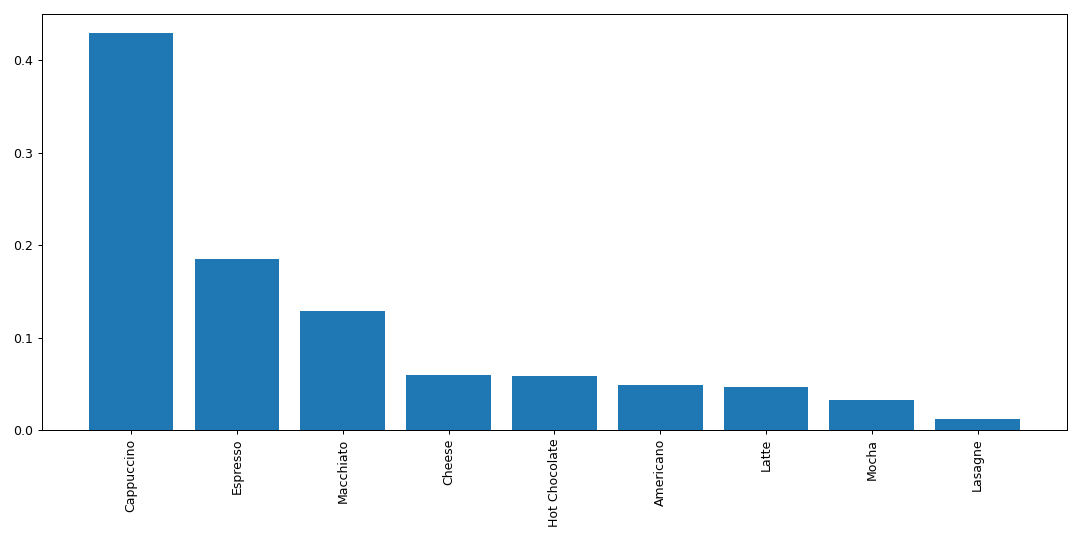

,feature,importance
0,Cappuccino,0.429172
1,Espresso,0.185238
2,Macchiato,0.128230
3,Cheese,0.059913
4,Hot Chocolate,0.058257
5,Americano,0.049117
6,Latte,0.046562
7,Mocha,0.032183
8,Lasagne,0.011328


In [22]:
rf = RandomForestRegressor(random_state = 5)
rf.fit(x,y)
importance = rf.feature_importances_

l = []
for i,v in enumerate(importance):
    l.append([x.columns[i],v])

df_l = pd.DataFrame(l,columns = ['feature','importance'])
df_l.sort_values(by = 'importance',ascending = False,inplace = True)
df_l.reset_index(drop = True,inplace = True)
df_l

print("R2-score: %.5f" % rf.score(x,y))
pyplot.rcParams["figure.figsize"] = (12,6)
pyplot.bar(df_l['feature'],df_l['importance'])
pyplot.xticks(rotation = 'vertical')
pyplot.tight_layout()

pyplot.show()
df_l

## Results <a name="results"></a>
---
* Cappuccino has the highest influence power on the venue's rating and guest loyalty.
* Despite the fact, that Americano is the most popular item among the coffee shops, it is only on the fifth place of the products, ranked by importance.


## Discussion <a name="discussion****"></a>

*Clearly, before the research was obvious, that the coffee shops owners have to have available in café most popular coffee drinks, such as Cappuccino, Macchiato, Espresso, Hot Chocolate, and Americano.*
But which items are more important for their guests was undetermined.

Now, entrepreneurs precisely know that the mentioned above 5 items are most important and their prices have an influence on the overall customer's rating. So, the recommendation for business owners is to keep the mentioned items on stock and carefully track their prices.

## Conclusion <a name="conclusion"></a>

To sum up, in this research, we have determined the connection between venue's rating and availability of the most popular items (incl. their prices).
We have identified the most important for coffee shop's rating items and numerically described their influence on the overall venue's rating.